In [1]:
import numpy as np
from numpy.ctypeslib import ndpointer
import matplotlib.pyplot as plt
import pandas as pd
import math as m
import ctypes as ct

def plot(signal):
    n = len(signal)
    x = np.arange(n)
    plt.stem(x, signal)
    plt.grid()
    plt.show()

array = lambda arr: np.asarray(arr, dtype=np.float32) 
print_error = lambda x1, x2: print("Error: ", np.sqrt((x1 - x2) ** 2).mean())
np_fft = lambda x: np.abs(np.fft.fft(x))

lib = ct.CDLL('./lib.so')
argtypes = [ndpointer(np.float32, flags="C_CONTIGUOUS"), ndpointer(np.complex64, flags="C_CONTIGUOUS"), ct.c_size_t]
lib.fft.argtypes = argtypes
lib.fft_parallel.argtypes = argtypes
lib.fft_parallel_opt.argtypes = argtypes

def my_fft(x):
    n = len(x)
    out = np.empty(n, dtype=np.complex64)
    lib.fft(x, out, n)
    return np.abs(out)

def my_fft_parallel(x):
    n = len(x)
    out = np.empty(n, dtype=np.complex64)
    lib.fft_parallel(x, out, n)
    return np.abs(out)

def my_fft_parallel_opt(x):
    n = len(x)
    out = np.empty(n, dtype=np.complex64)
    lib.fft_parallel_opt(x, out, n)
    return np.abs(out)

lib.measure_time.restype = ct.c_double

def measure_time(func, size, nproc=6):
    lib.omp_set_num_threads(ct.c_int(nproc))
    return lib.measure_time(func, size)

def plot_size_time(func, x, label, show=0):
    y = np.array([])
    for size in x:
        y = np.append(y, measure_time(func, ct.c_size_t(size)))
    plt.plot(x, y, label=label)
    plt.xlabel('size, n'); plt.ylabel('time, s')
    plt.grid()
    plt.legend()
    if show:
        plt.show()

def plot_nproc_time(funcs, size, nproc):
    fig, ax1 = plt.subplots(figsize=(10,6))
    fig, ax2 = plt.subplots(figsize=(10,6))
    ax1.set(xlabel='threads number', ylabel='acceleration', title='Acceleration')
    ax2.set(xlabel='threads number', ylabel='efficiency', title='Efficiency')
    ax1.grid(); ax2.grid()

    for func in funcs:
        x = np.arange(1, nproc + 1)
        y = np.array([])
        for n in x:
            y = np.append(y, measure_time(func[1], ct.c_size_t(size), n))

        y = y[0] / y
        ax1.plot(x, y, label=func[0])
        y = y / x
        ax2.plot(x, y, label=func[0])

    ax1.legend(); ax2.legend()

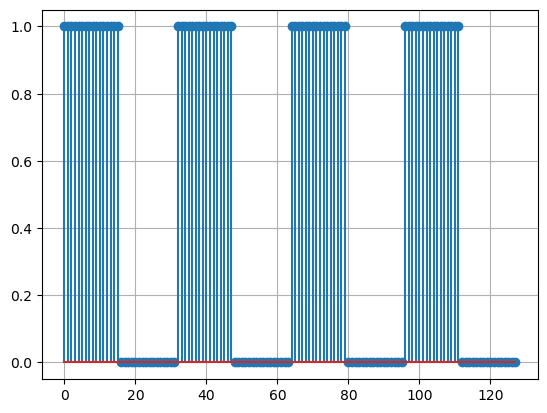

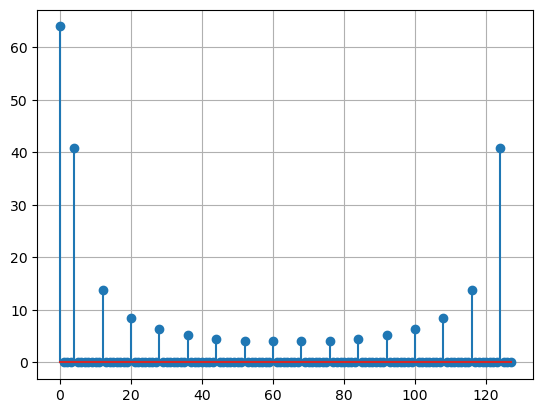

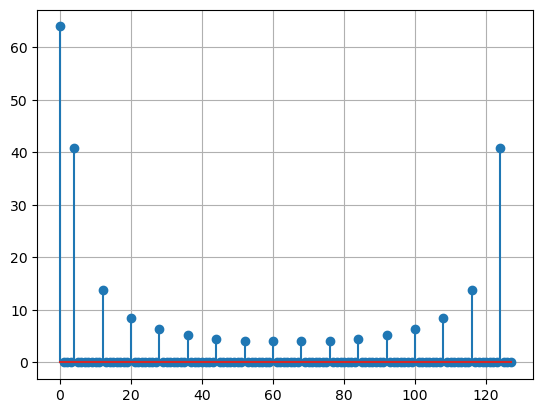

Error:  1.436959623443701e-07
Error:  1.436959623443701e-07
Error:  1.4462966670819588e-07


In [2]:
x = np.arange(128)
x = array(((x % 32) < 16))
plot(x)
plot(np_fft(x))
plot(my_fft(x))
print_error(np_fft(x), my_fft(x))
print_error(np_fft(x), my_fft_parallel(x))
print_error(np_fft(x), my_fft_parallel_opt(x))

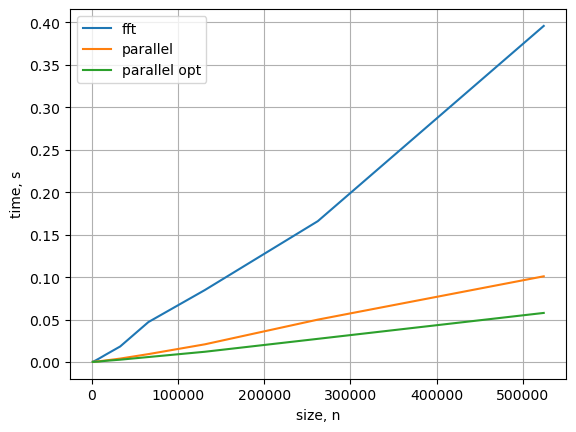

In [3]:
x = np.array([2 ** k for k in range(10, 20)], dtype=int)
plot_size_time(lib.fft, x, 'fft')
plot_size_time(lib.fft_parallel, x, 'parallel')
plot_size_time(lib.fft_parallel_opt, x, 'parallel opt', 1)

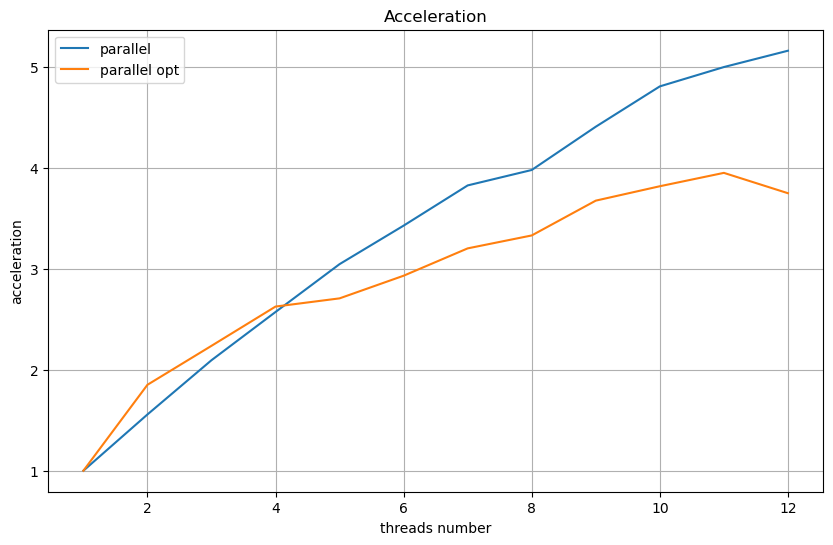

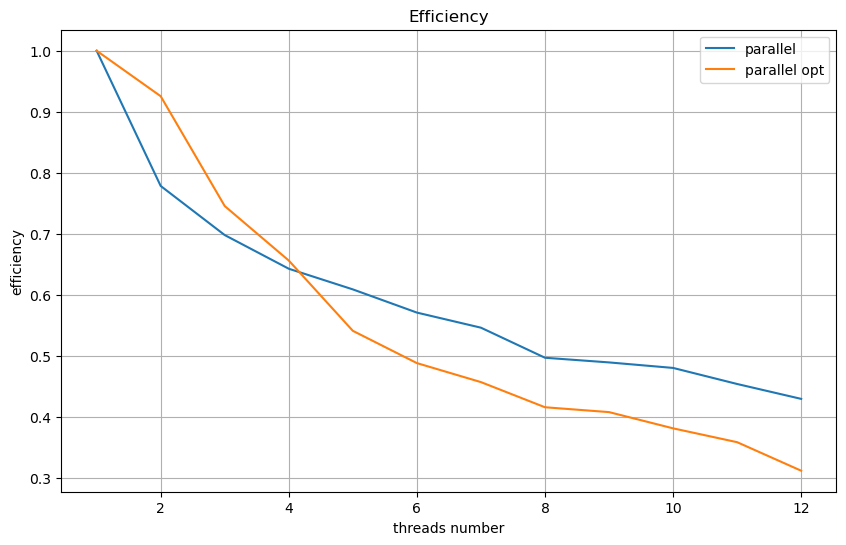

In [4]:
funcs = [['parallel', lib.fft_parallel],
         ['parallel opt', lib.fft_parallel_opt]]
plot_nproc_time(funcs, 2**23, 12)